# BLS Labor Statistics

We will now use the data that we downloaded to explore the labor market reactions during times of economic turbulence

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## Clean the data

We are going to assume that the data is stored in the same directory as you are in right now under `bls_metadata.parquet` and `bls_data.parquet`.

In [2]:
data = pd.read_parquet("bls_data.parquet")
metadata = pd.read_parquet("bls_metadata.parquet")


### Convert to numeric data

In [3]:
data["value"] = pd.to_numeric(data["value"])

### Convert date information to datetime


In [4]:
data.head()

,year,period,periodName,latest,value,series_id
0,2020,M09,September,true,147796,LNU02000000
1,2020,M08,August,None,147224,LNU02000000
2,2020,M07,July,None,144492,LNU02000000
3,2020,M06,June,None,142811,LNU02000000
4,2020,M05,May,None,137461,LNU02000000


In [5]:
data["dt"] = pd.to_datetime(
    data.apply(lambda x: f"1 {x['periodName']} {x['year']}", axis=1)
)

# Drop unneeded date info
data = data.drop(
    ["year", "periodName", "period", "latest"], axis=1
).sort_values(
    ["series_id", "dt"]
)[["series_id", "dt", "value"]]

data.head(3)


,series_id,dt,value
947,LNS12000000,2001-01-01,137778
946,LNS12000000,2001-02-01,137612
945,LNS12000000,2001-03-01,137783


### Rename `cps_labor_force_status`

In [6]:
lfs_status = {
    "Employed": "employed",
    "Unemployed": "unemployed",
    "Labor Force Flows Employed to Employed": "ee",
    "Labor Force Flows Employed to Unemployed": "eu",
    "Labor Force Flows Unemployed to Employed": "ue",
    "Labor Force Flows Unemployed to Unemployed": "uu",                
}

metadata = metadata.replace({"cps_labor_force_status": lfs_status})

metadata.head(2)


,series_title,series_id,seasonality,survey_name,survey_abbreviation,measure_data_type,commerce_industry,occupation,cps_labor_force_status,demographic_age,demographic_ethnic_origin,demographic_race,demographic_gender,demographic_marital_status,demographic_education
0,(Unadj) Employment Level,LNU02000000,Not Seasonally Adjusted,Labor Force Statistics from the Current Popula...,LN,Number in thousands,All Industries,All Occupations,employed,16 years and over,All Origins,All Races,Both Sexes,All marital statuses,All educational levels
1,(Unadj) Employment Level - Men,LNU02000001,Not Seasonally Adjusted,Labor Force Statistics from the Current Popula...,LN,Number in thousands,All Industries,All Occupations,employed,16 years and over,All Origins,All Races,Men,All marital statuses,All educational levels


### Only keep subset of metadata

In [7]:
and_filters = [
    "(commerce_industry == 'All Industries')",
    "(occupation == 'All Occupations')",
    "(seasonality == 'Not Seasonally Adjusted')",
    "(demographic_race == 'All Races')",
    "(demographic_gender == 'Both Sexes')",
]

metadata_lf = metadata.query(
    "&".join(and_filters)
).loc[metadata["cps_labor_force_status"].isin(lfs_status.values()), :]

metadata_lf.head(2)


,series_title,series_id,seasonality,survey_name,survey_abbreviation,measure_data_type,commerce_industry,occupation,cps_labor_force_status,demographic_age,demographic_ethnic_origin,demographic_race,demographic_gender,demographic_marital_status,demographic_education
0,(Unadj) Employment Level,LNU02000000,Not Seasonally Adjusted,Labor Force Statistics from the Current Popula...,LN,Number in thousands,All Industries,All Occupations,employed,16 years and over,All Origins,All Races,Both Sexes,All marital statuses,All educational levels
6,(Unadj) Labor Force Flows Employed to Employed,LNU07000000,Not Seasonally Adjusted,Labor Force Statistics from the Current Popula...,LN,Number in thousands,All Industries,All Occupations,ee,16 years and over,All Origins,All Races,Both Sexes,All marital statuses,All educational levels


### Merge variable names to `data`

In [8]:
df = pd.merge(
    data, metadata_lf[["series_id", "cps_labor_force_status"]],
    on="series_id", how="right"
).rename(
    columns={"cps_labor_force_status": "variable"}
)[["variable", "dt", "value"]]

df.head()


,variable,dt,value
0,employed,2001-01-01,136181
1,employed,2001-02-01,136577
2,employed,2001-03-01,137155
3,employed,2001-04-01,137022
4,employed,2001-05-01,137121


## Generate series from dates

Create a function that will give us a series starting from a particular date and going forward a certain number of days

In [9]:
def filter_days_from(data, start_date, ndays=3*365):
    """
    Creates a history of data starting at a particular date and running
    forward for `ndays` days.
    
    Parameters
    ----------
    data : pd.DataFrame
        A DataFrame with relevant data that we'd like to  consider
        starting from a particular date. Must have a column `dt` with
        datetime data
    start_date : str or datetime
        The moment we would like our history to start
    ndays : int
        The number of days that we would like to keep in our history
    
    Returns
    -------
    out : pd.DataFrame
        A copy of `data` with only data from `start_date` to
        `start_date + f'{ndays} days'` and a new column that counts
        the number of days since `start_date`
    """
    # Determine number of days from certain date
    days_from = (data["dt"] - pd.to_datetime(start_date)).dt.days
    
    # Check for >=0 days and <ndays
    dates_to_keep = (days_from >= 0) & (days_from < ndays)
    
    # Create copy of DataFrame that we'll use as the return
    out = data.copy()
    out["days_from"] = days_from
    out = out.loc[dates_to_keep, :]

    return out

### What does this function do?

In [10]:
df_nt = filter_days_from(df, "2012-01-01", ndays=5*365)

df_nt.head()


,variable,dt,value,days_from
132,employed,2012-01-01,139944,0
133,employed,2012-02-01,140684,31
134,employed,2012-03-01,141412,60
135,employed,2012-04-01,141995,91
136,employed,2012-05-01,142727,121


## UE and EU during 'normal times'

In [11]:
pt_nt = df_nt.pivot(index="dt", columns="variable", values="value")

pt_nt["laborforce"] = pt_nt.eval("employed + unemployed")

for col in ["ee", "eu"]:
    pt_nt.loc[:, col] = pt_nt.eval(f"{col} / employed")

for col in ["ue", "uu"]:
    pt_nt.loc[:, col] = pt_nt.eval(f"{col} / unemployed")

pt_nt.head()


variable,ee,employed,eu,ue,unemployed,uu,laborforce
dt,,,,,,,
2012-01-01,0.956647,139944,0.018457,0.145189,13541,0.587180,153485
2012-02-01,0.956989,140684,0.014422,0.188980,13430,0.618764,154114
2012-03-01,0.959077,141412,0.013485,0.188779,12904,0.634997,154316
2012-04-01,0.960273,141995,0.010944,0.199412,11910,0.651637,153905
2012-05-01,0.959916,142727,0.011764,0.169668,12271,0.605330,154998


Text(0.5, 1.0, "EU and UE during 'normal times'")

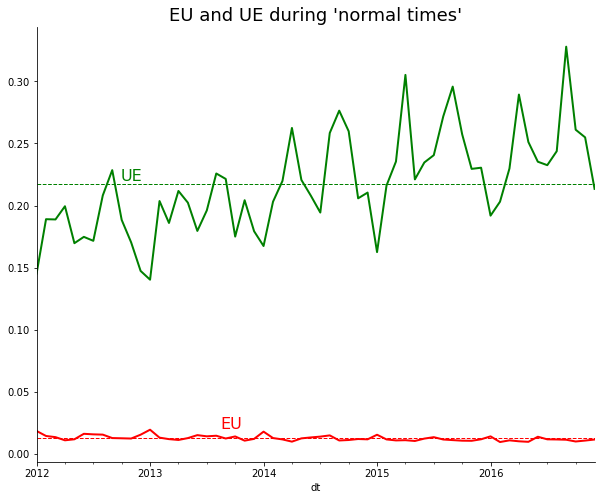

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

pt_nt.plot(
    y="eu", ax=ax,
    color="Red", legend=False, linewidth=2.0
)
pt_nt.plot(
    y="ue", ax=ax,
    color="Green", legend=False, linewidth=2.0
)

ax.hlines(
    pt_nt["eu"].mean(), pt_nt.index[0], pt_nt.index[-1],
    linewidth=1.0, linestyle="--", color="Red"
)
ax.hlines(
    pt_nt["ue"].mean(), pt_nt.index[0], pt_nt.index[-1],
    linewidth=1.0, linestyle="--", color="Green"
)

xs, xe = ax.get_xlim()
ax.annotate(
    "EU", xy=(xs + 0.33*(xe-xs), 0.020),
    color="Red", size=16
)
ax.annotate(
    "UE", xy=(xs + 0.15*(xe-xs), 0.22),
    color="Green", size=16
)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_title("EU and UE during 'normal times'", size=18)

## Labor statistics during 'turbulent times'

We are going to start our plots of "turbulent times" one year prior to the trough of unemployment...


Note that we did this approximately, but writing code to do this would be a great exercise if you're looking for practice!

In [13]:
df_covid = filter_days_from(
    df, "2019-03-01", 5*365
).pivot(
    index="days_from", columns="variable", values="value"
).assign(
    laborforce= lambda x: x.eval("employed + unemployed"),
    ee=lambda x: x.eval("ee / employed"),
    eu=lambda x: x.eval("eu / employed"),
    ue=lambda x: x.eval("ue / unemployed"),
    uu=lambda x: x.eval("uu / unemployed"),
)


In [14]:
df_gr = filter_days_from(
    df, "2007-02-01", 5*365
).pivot(
    index="days_from", columns="variable", values="value"
).assign(
    laborforce= lambda x: x.eval("employed + unemployed"),
    ee=lambda x: x.eval("ee / employed"),
    eu=lambda x: x.eval("eu / employed"),
    ue=lambda x: x.eval("ue / unemployed"),
    uu=lambda x: x.eval("uu / unemployed"),
)


### Changes in employment and unemployment

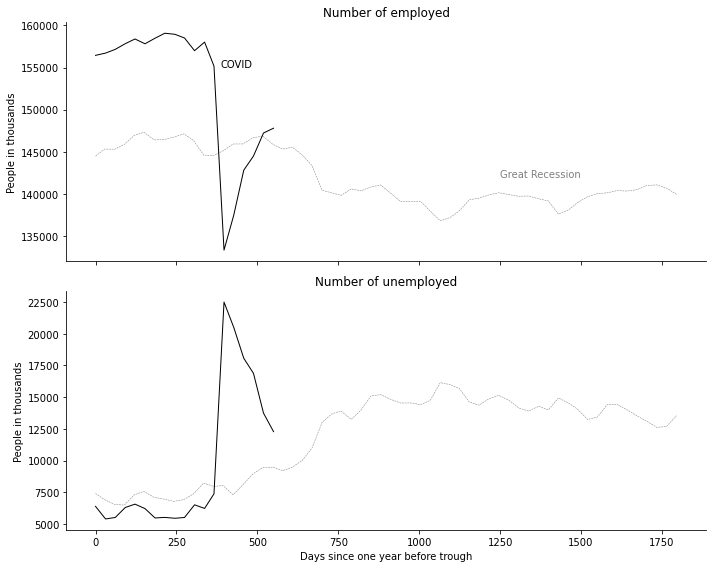

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

df_covid.plot(
    y="employed", ax=ax[0],
    color="k", linewidth=1.0, legend=False
)
df_gr.plot(
    y="employed", ax=ax[0],
    color="k", alpha=0.5, linestyle="--", linewidth=0.5,
    legend=False
)
ax[0].set_title("Number of employed")
ax[0].set_ylabel("People in thousands")

df_covid.plot(
    y="unemployed", ax=ax[1],
    color="k", linewidth=1.0, legend=False
)
df_gr.plot(
    y="unemployed", ax=ax[1],
    color="k", alpha=0.5, linestyle="--", linewidth=0.5,
    legend=False
)
ax[1].set_title("Number of unemployed")
ax[1].set_xlabel("Days since one year before trough")
ax[1].set_ylabel("People in thousands")

for _ax in ax:
    _ax.spines["right"].set_visible(False)
    _ax.spines["top"].set_visible(False)

ax[0].annotate("COVID", (385, 155_000))
ax[0].annotate("Great Recession", (1_250, 142_000), alpha=0.5)

fig.tight_layout()

### Changes in EU and UE

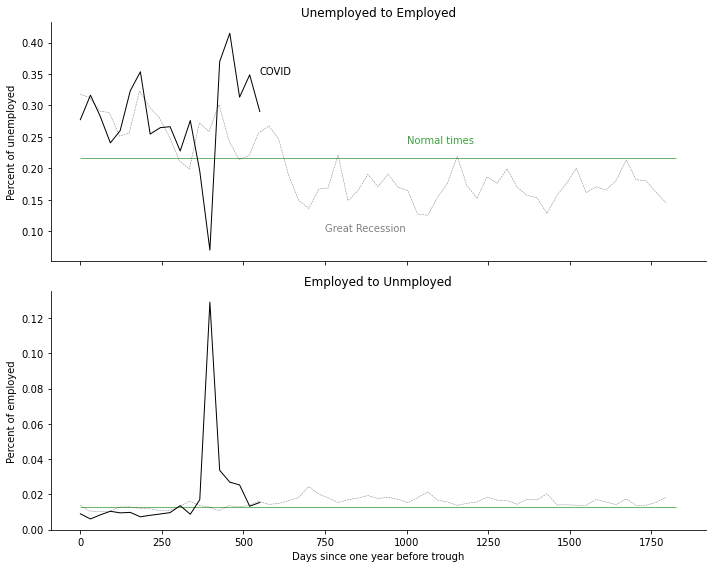

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

df_covid.plot(
    y="ue", ax=ax[0],
    color="k", linewidth=1.0, legend=False
)
df_gr.plot(
    y="ue", ax=ax[0],
    color="k", alpha=0.5, linestyle="--", linewidth=0.5,
    legend=False
)
ax[0].set_title("Unemployed to Employed")
ax[0].set_ylabel("Percent of unemployed")

df_covid.plot(
    y="eu", ax=ax[1],
    color="k", linewidth=1.0, legend=False
)
df_gr.plot(
    y="eu", ax=ax[1],
    color="k", alpha=0.5, linestyle="--", linewidth=0.5,
    legend=False
)
ax[1].set_title("Employed to Unmployed")
ax[1].set_xlabel("Days since one year before trough")
ax[1].set_ylabel("Percent of employed")

for _ax in ax:
    _ax.spines["right"].set_visible(False)
    _ax.spines["top"].set_visible(False)

ax[0].hlines(pt_nt["ue"].mean(), 0, 5*365, color="Green", linewidth=0.75, alpha=0.75)
ax[1].hlines(pt_nt["eu"].mean(), 0, 5*365, color="Green", linewidth=0.75, alpha=0.75)

ax[0].annotate("COVID", (550, 0.35))
ax[0].annotate("Great Recession", (750, 0.10), alpha=0.5)
ax[0].annotate("Normal times", (1000, 0.24), color="Green", alpha=0.75)

fig.tight_layout()
